Load up Libraries...

In [1]:
library(tidyverse)
library(caret)
library(randomForest)  # random forest, caret will load this automatically
library(kernlab) # SVM, caret will load this automatically

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



ERROR: Error in library(kernlab): there is no package called ‘kernlab’


Load up the data, be sure to set the target variable as a factor (For R)

In [3]:
dga <- read_csv("../../Data/dga-full.csv") %>%
  mutate(dsrc = factor(dsrc))

Parsed with column specification:
cols(
  dsrc = col_character(),
  domain = col_character(),
  length = col_integer(),
  dicts = col_double(),
  entropy = col_double(),
  numbers = col_integer(),
  ngram = col_double()
)


### Split data into a training and testing data set

Within `caret` the function `createDataPartition` can take in a vector, 
usually the class you want to predict on, so it can stratify the selection. In other words, 
if you have an unbalanced class, with 60% of one class and 40% of another,
`createDataPartition` will split with the same proportions, so the training data has the
same 60/40 split. 

For this, let's create a rather small training data se as it will reduce the time to train up a model.  
Feel free to try a 15%, 20% or even a 30% portion for the training data (lower percentages for slower machines).

In this example, we will split 30% for train and 70% for test.

Normally you would want most of the data in the training data, but more training data can considerably extend
the time neede to train up a model. 

### Just extract the data for "alexa" and "gameoverdga"

We will be creating a two-class classifier.

In [4]:
dga2 <- dga %>% 
  mutate(dsrc = as.character(dsrc)) %>% 
  dplyr::filter(dsrc %in% c("alexa", "gameoverdga")) %>% 
  mutate(dsrc = factor(dsrc))

# for 30/70 train/test, set p = 0.3, or p= 0.15 for 15% split
set.seed(1) # make the split repeatable
trainrows <- createDataPartition(dga2$dsrc, p = 0.2, list = FALSE)

traindata <- dga2[trainrows, ]
testdata <- dga2[-trainrows, ]

### Train both a Random Forest and Support Vector Machine on these. 

Traing the first model using Random Forest, and the second for a Support Vector Machine.

We will compare the two and see which performs better on the data.

In [11]:
ctrl <- trainControl(method="repeatedcv", # do cross validation
                     repeats=5, # 5 folds
                     classProbs=TRUE)  # save the probabilities (may speed up if FALSE)

# remember random forsts do no need to be scaled at all
rfFit <- train(dsrc ~ length + dicts + entropy + numbers + ngram,
               data = traindata,
               method = "rf",
               trControl = ctrl)
print(rfFit)
svmFit <- train(dsrc ~ length + dicts + entropy + numbers + ngram,
                data = traindata,
                method = "svmRadial",
                preProc = c("center", "scale"), # data for SVM can't be on totally different scales, so scale the input data
                tuneLength = 10,
                trControl = ctrl)
print(svmFit)

Random Forest 

4000 samples
   5 predictor
   2 classes: 'alexa', 'gameoverdga' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 3600, 3600, 3600, 3600, 3600, 3600, ... 
Resampling results across tuning parameters:

  mtry  Accuracy  Kappa 
  2     0.99975   0.9995
  3     0.99970   0.9994
  5     0.99975   0.9995

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 2.


Loading required package: kernlab

Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha



Support Vector Machines with Radial Basis Function Kernel 

4000 samples
   5 predictor
   2 classes: 'alexa', 'gameoverdga' 

Pre-processing: centered (5), scaled (5) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 3600, 3600, 3600, 3600, 3600, 3600, ... 
Resampling results across tuning parameters:

  C       Accuracy  Kappa
    0.25  1         1    
    0.50  1         1    
    1.00  1         1    
    2.00  1         1    
    4.00  1         1    
    8.00  1         1    
   16.00  1         1    
   32.00  1         1    
   64.00  1         1    
  128.00  1         1    

Tuning parameter 'sigma' was held constant at a value of 1.351336
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were sigma = 1.351336 and C = 0.25.


### Look at the confusion matrix on the Random Forest model using the test data 

In [12]:
print(confusionMatrix(predict(rfFit, testdata), testdata$dsrc))

Confusion Matrix and Statistics

             Reference
Prediction    alexa gameoverdga
  alexa        7999           0
  gameoverdga     1        8000
                                     
               Accuracy : 0.9999     
                 95% CI : (0.9997, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : <2e-16     
                                     
                  Kappa : 0.9999     
 Mcnemar's Test P-Value : 1          
                                     
            Sensitivity : 0.9999     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 0.9999     
             Prevalence : 0.5000     
         Detection Rate : 0.4999     
   Detection Prevalence : 0.4999     
      Balanced Accuracy : 0.9999     
                                     
       'Positive' Class : alexa      
                                     


### Look at the confusion matrix on the SVM model using the test data 

In [14]:
print(confusionMatrix(predict(svmFit, testdata), testdata$dsrc))

Confusion Matrix and Statistics

             Reference
Prediction    alexa gameoverdga
  alexa        8000           0
  gameoverdga     0        8000
                                     
               Accuracy : 1          
                 95% CI : (0.9998, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : alexa      
                                     


Which one looks better?

### Look at the variable importance in the Random Forest Model

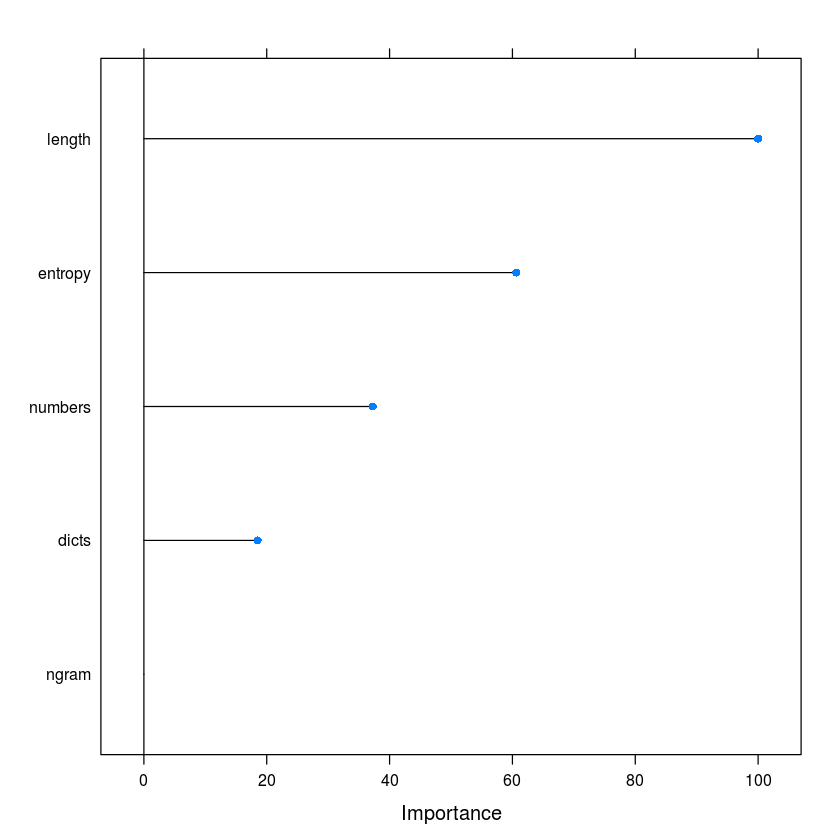

In [15]:
plot(varImp(rfFit))

### For Fun, look at the predicted probabilities.

Could even plot the predicted probabilities using a density (or histogram) plot.

In [16]:
rez <- predict(rfFit, testdata, type="prob")
summary(rez)

     alexa         gameoverdga    
 Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.4290   Median :0.5710  
 Mean   :0.5001   Mean   :0.4999  
 3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000  


Note the above summary shows two probabilities, the probability the observation
is from "alexa" and the probability the observation is from "gameoverdga".  They 
should add up to 1.  

So, if we just take one column, like the `gameoverdga` column, it will tell us the probability of the domain being a DGA.  I will grab just that column, but then separate it into the 
ground truth, so we see the probability of a domain being a DGA when it is or is not a DGA.

In [17]:
# add in the real label
rez$dsrc <- testdata$dsrc

### look at spread of just the "gameoverdga" value by the dsrc
rez %>% 
  # group by dsrc so we can number them
  group_by(dsrc) %>% 
  # the row numbers will make the final even compact
  mutate(rownum = row_number()) %>% 
  select(-alexa) %>% 
  spread(dsrc, gameoverdga) %>% 
  select(-rownum) %>% 
  summary

     alexa            gameoverdga    
 Min.   :0.0000000   Min.   :0.5160  
 1st Qu.:0.0000000   1st Qu.:1.0000  
 Median :0.0000000   Median :1.0000  
 Mean   :0.0006145   Mean   :0.9993  
 3rd Qu.:0.0000000   3rd Qu.:1.0000  
 Max.   :0.9840000   Max.   :1.0000  